In [83]:
using PyPlot
using Random
using LinearAlgebra

We consider $3$-layer linear neural networks trained with gradient descent on the square loss. We write the predictor
$$
F(U,V,W) = \frac12 \mathbb{E}_{x,y}[ \Vert V W U x - y\Vert^2]
$$
Our choice of scales of initialization (as a function of width $m$) can be understood as follows:
- the preactivation are of order $\Theta(1)$ (standard initialization), except for the output layer, which should be $O(1/m)$ to avoid lazy training (and thus obtain a richer, non-linear dynamics).
- then the layerwise learning-rates are adjusted so that all layers contribute equally to the dynamics of the predictor.

# Functions

Run GD on a the linear NN with rnadom init

In [19]:
"GD on a linear neural net of depth 3, random init"
function GD_3LNN_random(X, Y; m=100, niter=100, lr=0.1)
    d,n = size(X)
    U0 = randn(m,d) # init input layer
    W0 = randn(m,m)/sqrt(m) # init intermediate layer
    V0 = randn(1,m)/m       # init output layer
    loss = zeros(niter)
    track = zeros(niter) # choose a quantity to track down
    λs = zeros(d,niter)

    U = U0
    W = W0
    V = V0
    for t = 1:niter
        #@show size(V), size(W), size(U), size(X)
        P = V*W*U*X
        ξ = P - Y # gradient of the loss
        loss[t] = sum(ξ.^2)/2
        track[t] = m*sum(V.^2)
        λs[:,t] = (V*W*U)[:]
        dV = - sum(ξ[i]*X[:,i]'*U'*W' for i=1:n)/m
        dU = - sum(ξ[i]*W'*V'*X[:,i]' for i=1:n)*m
        dW = - sum(ξ[i]*V'*X[:,i]'*U'  for i=1:n)
        U = U + lr*dU
        V = V + lr*dV
        W = W + lr*dW
    end
    return loss, track, λs
end

GD_3LNN_random

As a side note we can write the model in the normalized quantities (this function is not used hereafter).

In [5]:
"GD on a linear neural net of depth 3, random init (same but parameterized with explicit scalings)"
function GD_3LNN_random_norm(X, Y; m=100, niter=100, lr=0.1)
    # same output as the previous function, but different variables inside
    d,n = size(X)
    U0 = randn(m,d)       # init input layer
    Z  = randn(m,m)
    W0 = zeros(m,m)       # init intermediate layer
    V0 = randn(1,m)       # init output layer
    loss = zeros(niter)
    track = zeros(niter)

    U = U0
    W = W0
    V = V0
    for t = 1:niter
        P = (1/m)*V*(Z/sqrt(m) + W/m)*U*X
        ξ = P - Y # gradient of the loss
        loss[t] = sum(ξ.^2)/2
        track[t] = sum(V.^2)/m
        dV = - sum(ξ[i]*X[:,i]'*U'*(Z/sqrt(m) + W/m)' for i=1:n)
        dU = - sum(ξ[i]*(Z/sqrt(m) + W/m)'*V'*X[:,i]' for i=1:n)
        dW = - sum(ξ[i]*V'*X[:,i]'*U'  for i=1:n)
        U = U + lr*dU
        V = V + lr*dV
        W = W + lr*dW
    end
    return loss, track
end

GD_3LNN_random_norm

GD on the limit model

In [6]:
"GD on a linear neural net of depth 3; initialization obtained in the limit model"
function GD_3LNN_limit(X, Y; m=100, niter=100, lr=0.1, scale = 1.0)
    d,n = size(X)
    U0 = zeros(m,d) # init input layer
    for i=1:d
        U0[i,i] = 1
    end
    W0 = zeros(m,m) # init intermediate layer
    for i=1:m-1
        W0[i+1,i] = 1
    end
    for i=1:m-d
        W0[i,i+d] = 1
    end
    V0 = zeros(1,m) # init output layer
    V0[1] = 1

    loss  = zeros(niter)
    track = zeros(niter)
    Vs = zeros(m,niter)
    λs = zeros(d,niter)

    U = U0
    W = W0
    V = V0
    for t = 1:niter 
        P = scale*V*W*U*X
        ξ = P - Y # gradient of the loss
        loss[t] = sum(ξ.^2)/2
        track[t] = sum(V.^2)
        λs[:,t] = (scale*V*W*U)[:]
        Vs[:,t] = V[:]
        dV = - sum(ξ[i]*X[:,i]'*U'*W' for i=1:n)
        dU = - sum(ξ[i]*W'*V'*X[:,i]' for i=1:n)
        dW = - sum(ξ[i]*V'*X[:,i]'*U'  for i=1:n)
        U = U + lr*dU
        V = V + lr*dV
        W = W + lr*dW
    end
    return loss, track, λs, Vs
end

GD_3LNN_limit

# Produce figures for the paper

## 0. Generate synthetic data

In [108]:
Random.seed!(2)
d = 20    # input dimension
n = 15   # nb data points
X = randn(d,n)/sqrt(d) # input data
λ = randn(d) # optimal linear predictor [in the population limit]
Y = λ'*X # labels
λ_opt = pinv(X*X')*(X*Y')# min ell_2 interpolator;

## I. Verifying convergence in the large width

In [118]:
niter = 1000
lr = 0.02
ms = [10,100,1000]
nrep = 10
losss = zeros(niter,length(ms),nrep)
tracks = zeros(niter,length(ms),nrep)
lambdas = zeros(d,niter,length(ms),nrep)
@time for i = 1:length(ms)
    for j= 1:nrep
        loss, track, λs = GD_3LNN_random(X, Y, m =  ms[i], niter = niter, lr = lr)
        losss[:,i,j] = loss
        tracks[:,i,j] = track
        lambdas[:,:,i,j] = λs
    end
end

790.962818 seconds (15.90 M allocations: 3.540 TiB, 1.11% gc time)


In [113]:
niter = 2000
loss_lim, track_lim, λs_lim = GD_3LNN_limit(X, Y; m = 100, niter = niter, lr = lr);

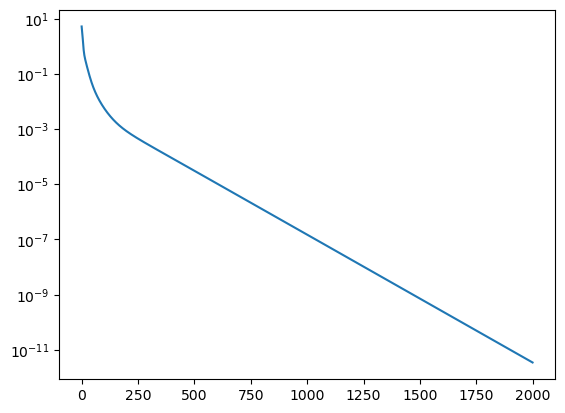

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f9ed6176520>

In [125]:

semilogy(loss_lim)

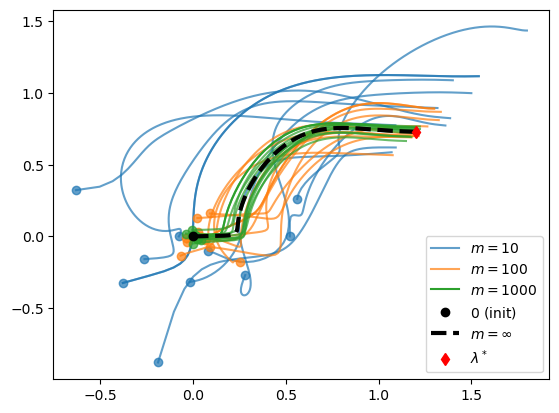

PyObject <matplotlib.legend.Legend object at 0x7f9db142dfd0>

In [215]:

al=0.7

i=1
for j=1:nrep
plot(lambdas[1,1,i,j],lambdas[2,1,i,j],"o", c="C0",alpha=al)
    plot(lambdas[1,:,i,j],lambdas[2,:,i,j],"-", c="C0",alpha=al)
end
plot(lambdas[1,:,i,1],lambdas[2,:,i,1],"-", label=L"$m=10$", c="C0",alpha=al)
i=2
for j=1:nrep
plot(lambdas[1,1,i,j],lambdas[2,1,i,j],"o", c="C1",alpha=al)
    plot(lambdas[1,:,i,j],lambdas[2,:,i,j],"-", c="C1",alpha=al)
end
plot(lambdas[1,:,i,1],lambdas[2,:,i,1],"-", label=L"$m=100$", c="C1",alpha=al)
i=3
for j=1:nrep
plot(lambdas[1,1,i,j],lambdas[2,1,i,j],"o", c="C2",alpha=al)
    plot(lambdas[1,:,i,j],lambdas[2,:,i,j],"-", c="C2",alpha=al)
end
plot(lambdas[1,:,i,1],lambdas[2,:,i,1],"-", label=L"$m=1000$", c="C2")

plot(0,0,"ko",label=L"$0$ (init)")
plot(λs_lim[1,1:1000],λs_lim[2,1:1000],"--k",lw=3, label=L"$m=\infty$")

plot(λ_opt[1],λ_opt[2],"rd",label=L"\lambda^*")
legend()

#savefig("3LNN-traj.png", bbox_inches="tight")

Figure 1(A)

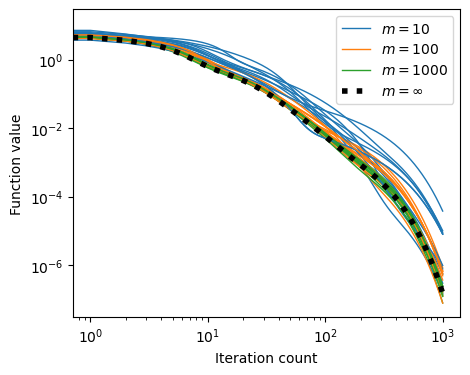

PyObject Text(0.5, 24.0, 'Iteration count')

In [128]:
figure(figsize=[5,4])

niter = 100
lr = 0.02
m = 10
for k = 1:nrep
    loglog(losss[:,1,k], lw=1,"C0")
    loglog(losss[:,2,k], lw=1,"C1")
    loglog(losss[:,3,k], lw=1,"C2")
end
loglog(losss[:,1,1], lw=1,"C0",label=L"m=10")
loglog(losss[:,2,1], lw=1,"C1",label=L"m=100")
loglog(losss[:,3,1], lw=1,"C2",label=L"m=1000")

loglog(loss_lim[1:1000],":k",lw=4, label=L"m=\infty")

#axis([1,niter,0,20])
legend()
ylabel("Function value")
xlabel("Iteration count")

#savefig("3LNN-loss.png", bbox_inches="tight")

Figure 1(B)

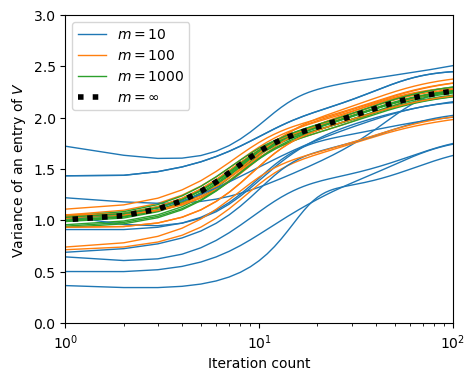

PyObject Text(0.5, 24.0, 'Iteration count')

In [137]:
figure(figsize=[5,4])

for k = 1:nrep
    semilogx(tracks[:,1,k], lw=1,"C0")
    semilogx(tracks[:,2,k], lw=1,"C1")
    semilogx(tracks[:,3,k], lw=1,"C2")
end
semilogx(tracks[:,1,1], lw=1,"C0",label=L"m=10")
semilogx(tracks[:,2,1], lw=1,"C1",label=L"m=100")
semilogx(tracks[:,3,1], lw=1,"C2",label=L"m=1000")

semilogx(track_lim,":k",lw=4, label=L"m=\infty")

axis([1,niter,0,3])
legend()
ylabel(L"Variance of an entry of $V$")
xlabel("Iteration count")

#savefig("3LNN-track.png", bbox_inches="tight")

A nicer lot?

In [207]:
niter = 1000
lr = 0.02
ms = [10,100,1000]
nrep = 10
lambdas = zeros(d,niter,length(ms),nrep)
@time for i = 1:length(ms)
    for j= 1:nrep
        loss, track, λs = GD_3LNN_random(X, Y, m =  ms[i], niter = niter, lr = lr)
        lambdas[:,:,i,j] = λs
    end
end

742.604639 seconds (15.90 M allocations: 3.540 TiB, 1.80% gc time)


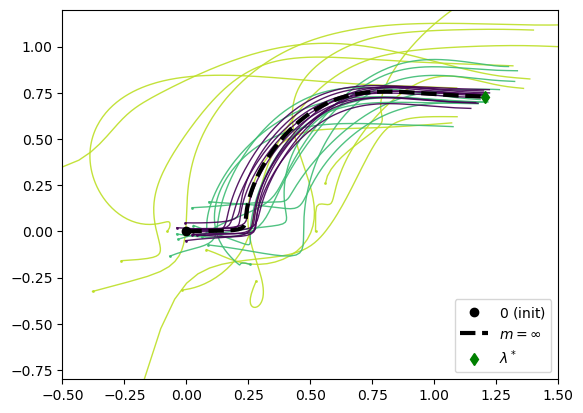

In [214]:
al=0.9
cmap = ColorMap("viridis_r")
for i=1:length(ms)
for j=1:nrep
        plot(lambdas[1,1,i,j],lambdas[2,1,i,j],"o", c=cmap(((ms[i])/(ms[end]))^(1/2)),alpha=al,ms=1)
        plot(lambdas[1,:,i,j],lambdas[2,:,i,j],"-", c=cmap(((ms[i])/(ms[end]))^(1/2)),alpha=al,lw=1)
end
end
#plot(lambdas[1,:,i,1],lambdas[2,:,i,1],"-", label=L"$m=10$", c="C0",alpha=al)

plot(0,0,"ko",label=L"$0$ (init)")
plot(λs_lim[1,1:1000],λs_lim[2,1:1000],"--k",lw=3, label=L"$m=\infty$")

plot(λ_opt[1],λ_opt[2],"gd",label=L"\lambda^*")
legend()
#colorbar()
axis([-0.5,1.5,-0.8,1.2])
savefig("3LNN-traj-2.png", bbox_inches="tight",dpi=250)

## Exploring behavior of the limit model and the effect of scale

In [ ]:
niter = 10000
lr = 0.001
loss_lim, track_lim, λs, Vs = GD_3LNN_limit(X, Y; m = 100, niter = niter, lr = lr, scale=1.0);

In [ ]:
loglog(loss_lim)

In [ ]:
ts = Int.(floor.(10 .^ (0:0.1:2)))
for t in ts
    figure(figsize=[4,4])
    stem(Vs[:,t])
    axis([0,30,-0.5,1.5])
    #savefig("3LNN-V$(t).png")
end

Compare the dynamics with GD

In [ ]:
niter = 50000
lr = 0.4
# Compute the trajectory of GD on ordinary least-squares (for comparison)
la = zeros(d,niter)
loss_lim = zeros(niter-1)
for t=1:niter-1
    loss_lim[t] = sum((X'*la[:,t] .- Y').^2)/2
    la[:,t+1] = la[:,t] - lr * X*(X'*la[:,t] .- Y')
end

In [ ]:
# Compute the trajectory of GD on the limit 3-layer linear NN with various scales
niter = 10000
lr = 0.001
loss_lim10, track_lim, λs10, Vs = GD_3LNN_limit(X, Y; m = 100, niter = niter, lr = lr, scale=10.0);
loss_lim1, track_lim, λs1, Vs = GD_3LNN_limit(X, Y; m = 100, niter = niter, lr = lr, scale=1.0);
loss_lim01, track_lim, λs01, Vs = GD_3LNN_limit(X, Y; m = 100, niter = niter, lr = lr, scale=0.1);
loss_lim001, track_lim, λs001, Vs = GD_3LNN_limit(X, Y; m = 100, niter = niter, lr = lr, scale=0.01);

Figure 2(A)

In [ ]:
figure(figsize=[5,4])
plot(λs001[1,:],λs001[2,:],"-", label=L"$s=0.01$", c=cmap(0.1))
plot(λs01[1,:],λs01[2,:],"-", label=L"$s=0.1$", c=cmap(0.3))
plot(λs1[1,:],λs1[2,:],"-", label=L"$s=1$", c=cmap(0.6))
plot(λs10[1,:],λs10[2,:],"-",label=L"$s=10$", c=cmap(0.9))
plot(la[1,:],la[2,:],"k--", label=L"$s=\infty$")
plot(0,0,"ko",label=L"$0$ (init)")
plot(λ_opt[1],λ_opt[2],"rd",label=L"\lambda^*")
legend()
#savefig("3LNN-limit-scale.png", bbox_inches="tight")

Figure 2(B)

In [ ]:
figure(figsize=[5,4])
semilogy(loss_lim001[1:1500], c=cmap(0.1),lw=2,label=L"$s=0.01$")
semilogy(loss_lim01[1:1500], c=cmap(0.3),lw=2,label=L"$s=0.1$")
semilogy(loss_lim1[1:1500], c=cmap(0.6),lw=2,label=L"$s=1$")
semilogy(loss_lim10[1:1500], c=cmap(0.9),lw=2,label=L"$s=10$")
legend()
xlabel("Iteration count")
ylabel("Objective value")
#savefig("3LNN-limit-scale-obj.png", bbox_inches="tight")